# EDA - Análise Exploratória de Dados
## Projeto de Forecasting - Casos TJGO

Este notebook realiza uma análise exploratória completa dos dados seguindo a metodologia CRISP-DM para forecasting de séries temporais.

### Objetivos:
1. **Business Understanding**: Compreender o objetivo e métricas de sucesso
2. **Data Understanding**: Análise estatística descritiva e de série temporal
3. **Preparação para Data Preparation**: Identificar transformações necessárias


In [1]:
# Importações necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Configurações para melhor qualidade dos gráficos
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

print("✅ Bibliotecas importadas com sucesso!")


✅ Bibliotecas importadas com sucesso!


## 1. Business Understanding

### Objetivo do Projeto
Prever novos casos em um tribunal (TJGO) utilizando técnicas de forecasting de séries temporais.

### Hipóteses de Negócio
- **H1**: O número de casos tem sazonalidade anual (mais casos em certos meses)
- **H2**: Variáveis econômicas (SELIC, IPCA, desemprego) influenciam o número de casos
- **H3**: Há tendência de crescimento ao longo do tempo
- **H4**: Eventos externos (pandemia, crises) impactam significativamente

### Critérios de Sucesso
- **MAE < 5000**: Erro absoluto médio menor que 5000 casos
- **RMSE < 7000**: Raiz do erro quadrático médio menor que 7000 casos  
- **R² > 0.7**: Coeficiente de determinação maior que 0.7
- **Interpretabilidade**: Modelo deve permitir insights para tomada de decisão


In [2]:
# Carregamento dos dados
data_path = '../data/raw/base_consolidada_mensal_clean.csv'
df = pd.read_csv(data_path)

print(" Informações básicas dos dados:")
print(f"Shape: {df.shape}")
print(f"Período: {df['DATA'].min()} a {df['DATA'].max()}")
print(f"Total de observações: {len(df)}")
print("\n" + "="*50)

# Visualização das primeiras linhas
print("\n Primeiras 5 linhas:")
display(df.head())

print("\n Últimas 5 linhas:")
display(df.tail())


 Informações básicas dos dados:
Shape: (132, 10)
Período: 2014-01-01 a 2024-12-01
Total de observações: 132


 Primeiras 5 linhas:


,DATA,TAXA_SELIC,VAREJO_RESTRITO,VAREJO_AMPLIADO,IPCA,INADIMPLENCIA,TAXA_DESOCUPACAO,TOTAL_CASOS,qt_acidente,QT_ELEITOR
0,2014-01-01,10.50,100.38972,104.93475,0.55,2.84,6.5,14709.0,633.0,141784975
1,2014-02-01,10.75,91.98744,95.93231,0.69,2.86,6.8,14278.0,599.0,142099496
2,2014-03-01,10.75,96.71372,97.62026,0.92,2.88,7.2,16995.0,644.0,142153073
3,2014-04-01,11.00,96.36363,99.96465,0.67,2.92,7.2,13117.0,591.0,141455448
4,2014-05-01,11.00,101.35248,104.65342,0.46,3.00,7.0,17851.0,597.0,142446543



 Últimas 5 linhas:


,DATA,TAXA_SELIC,VAREJO_RESTRITO,VAREJO_AMPLIADO,IPCA,INADIMPLENCIA,TAXA_DESOCUPACAO,TOTAL_CASOS,qt_acidente,QT_ELEITOR
127,2024-08-01,10.50,106.82036,108.46853,-0.02,3.21,6.6,64466.0,258.0,158107807
128,2024-09-01,10.75,101.77042,103.83736,0.44,3.21,6.4,59388.0,265.0,158107807
129,2024-10-01,10.75,107.58736,110.63371,0.56,3.17,6.2,62976.0,302.0,157744453
130,2024-11-01,11.25,114.34025,111.35358,0.39,3.14,6.1,58713.0,225.0,157805603
131,2024-12-01,12.25,126.59699,117.62622,0.52,2.96,6.2,49359.0,303.0,157845670


In [3]:
# Preparação dos dados para análise temporal
df['DATA'] = pd.to_datetime(df['DATA'])
df = df.set_index('DATA').sort_index()

# Verificação de dados faltantes
print(" Análise de dados faltantes:")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Coluna': missing_data.index,
    'Valores_Faltantes': missing_data.values,
    'Percentual': missing_percent.values
}).sort_values('Valores_Faltantes', ascending=False)

display(missing_df)

# Informações sobre duplicatas
duplicates = df.index.duplicated().sum()
print(f"\n Duplicatas temporais: {duplicates}")

# Verificação de gaps temporais
date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS')
gaps = set(date_range) - set(df.index)
print(f" Gaps temporais: {len(gaps)}")
if gaps:
    print(f"Gaps encontrados: {sorted(list(gaps))}")


 Análise de dados faltantes:


,Coluna,Valores_Faltantes,Percentual
0,TAXA_SELIC,0,0.0
1,VAREJO_RESTRITO,0,0.0
2,VAREJO_AMPLIADO,0,0.0
3,IPCA,0,0.0
4,INADIMPLENCIA,0,0.0
5,TAXA_DESOCUPACAO,0,0.0
6,TOTAL_CASOS,0,0.0
7,qt_acidente,0,0.0
8,QT_ELEITOR,0,0.0



 Duplicatas temporais: 0
 Gaps temporais: 0


## 2. Data Understanding - Análise Estatística Descritiva


In [4]:
# Estatísticas descritivas completas
print(" Estatísticas Descritivas - Todas as Variáveis")
print("="*60)

# Estatísticas básicas
desc_stats = df.describe()
display(desc_stats)

# Estatísticas adicionais (skewness, kurtosis)
from scipy import stats

additional_stats = []
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        skewness = stats.skew(df[col].dropna())
        kurtosis = stats.kurtosis(df[col].dropna())
        additional_stats.append({
            'Variável': col,
            'Skewness': round(skewness, 3),
            'Kurtosis': round(kurtosis, 3),
            'CV': round(df[col].std() / df[col].mean(), 3) if df[col].mean() != 0 else np.nan
        })

additional_df = pd.DataFrame(additional_stats)
print("\n Estatísticas Adicionais (Skewness, Kurtosis, CV):")
display(additional_df)


 Estatísticas Descritivas - Todas as Variáveis


,TAXA_SELIC,VAREJO_RESTRITO,VAREJO_AMPLIADO,IPCA,INADIMPLENCIA,TAXA_DESOCUPACAO,TOTAL_CASOS,qt_acidente,QT_ELEITOR
count,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,1.320000e+02
mean,9.606061,97.891908,97.293794,0.472424,3.071970,10.486364,40147.871212,343.856061,1.481276e+08
std,3.934230,10.100472,9.672250,0.394315,0.436209,2.610512,13932.644413,115.862127,4.893753e+06
min,2.000000,75.016680,67.371110,-0.680000,2.110000,6.100000,13117.000000,193.000000,1.414554e+08
25%,6.500000,90.898880,90.391630,0.237500,2.857500,7.975000,27047.250000,265.000000,1.454302e+08
50%,10.750000,96.451150,97.163270,0.430000,3.040000,11.300000,42015.500000,294.000000,1.462740e+08
75%,13.250000,101.399035,102.867890,0.715000,3.390000,12.525000,50669.500000,394.500000,1.500096e+08
max,14.250000,131.810740,124.908930,1.620000,4.040000,14.900000,68009.000000,668.000000,1.582234e+08



 Estatísticas Adicionais (Skewness, Kurtosis, CV):


,Variável,Skewness,Kurtosis,CV
0,TAXA_SELIC,-0.492,-1.056,0.410
1,VAREJO_RESTRITO,1.267,1.759,0.103
2,VAREJO_AMPLIADO,0.153,0.232,0.099
3,IPCA,0.201,0.341,0.835
4,INADIMPLENCIA,-0.254,-0.338,0.142
5,TAXA_DESOCUPACAO,-0.106,-1.337,0.249
6,TOTAL_CASOS,-0.285,-0.962,0.347
7,qt_acidente,1.228,0.461,0.337
8,QT_ELEITOR,0.812,-0.649,0.033


In [5]:
# Análise específica da variável target (TOTAL_CASOS)
target = df['TOTAL_CASOS']

print(" Análise Detalhada da Variável Target (TOTAL_CASOS)")
print("="*50)

# Estatísticas específicas do target
target_stats = {
    'Média': target.mean(),
    'Mediana': target.median(),
    'Moda': target.mode().iloc[0] if not target.mode().empty else 'N/A',
    'Desvio Padrão': target.std(),
    'Variância': target.var(),
    'Mínimo': target.min(),
    'Máximo': target.max(),
    'Amplitude': target.max() - target.min(),
    'Coeficiente de Variação': target.std() / target.mean(),
    'Skewness': stats.skew(target),
    'Kurtosis': stats.kurtosis(target)
}

for stat, value in target_stats.items():
    print(f"{stat}: {value:.2f}")

# Identificação de outliers usando IQR
Q1 = target.quantile(0.25)
Q3 = target.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = target[(target < lower_bound) | (target > upper_bound)]
print(f"\n Outliers identificados: {len(outliers)}")
print(f"Limite inferior: {lower_bound:.0f}")
print(f"Limite superior: {upper_bound:.0f}")

if len(outliers) > 0:
    print("Outliers encontrados:")
    for date, value in outliers.items():
        print(f"  {date.strftime('%Y-%m')}: {value:.0f} casos")

 Análise Detalhada da Variável Target (TOTAL_CASOS)
Média: 40147.87
Mediana: 42015.50
Moda: 13117.00
Desvio Padrão: 13932.64
Variância: 194118580.33
Mínimo: 13117.00
Máximo: 68009.00
Amplitude: 54892.00
Coeficiente de Variação: 0.35
Skewness: -0.28
Kurtosis: -0.96

 Outliers identificados: 0
Limite inferior: -8386
Limite superior: 86103


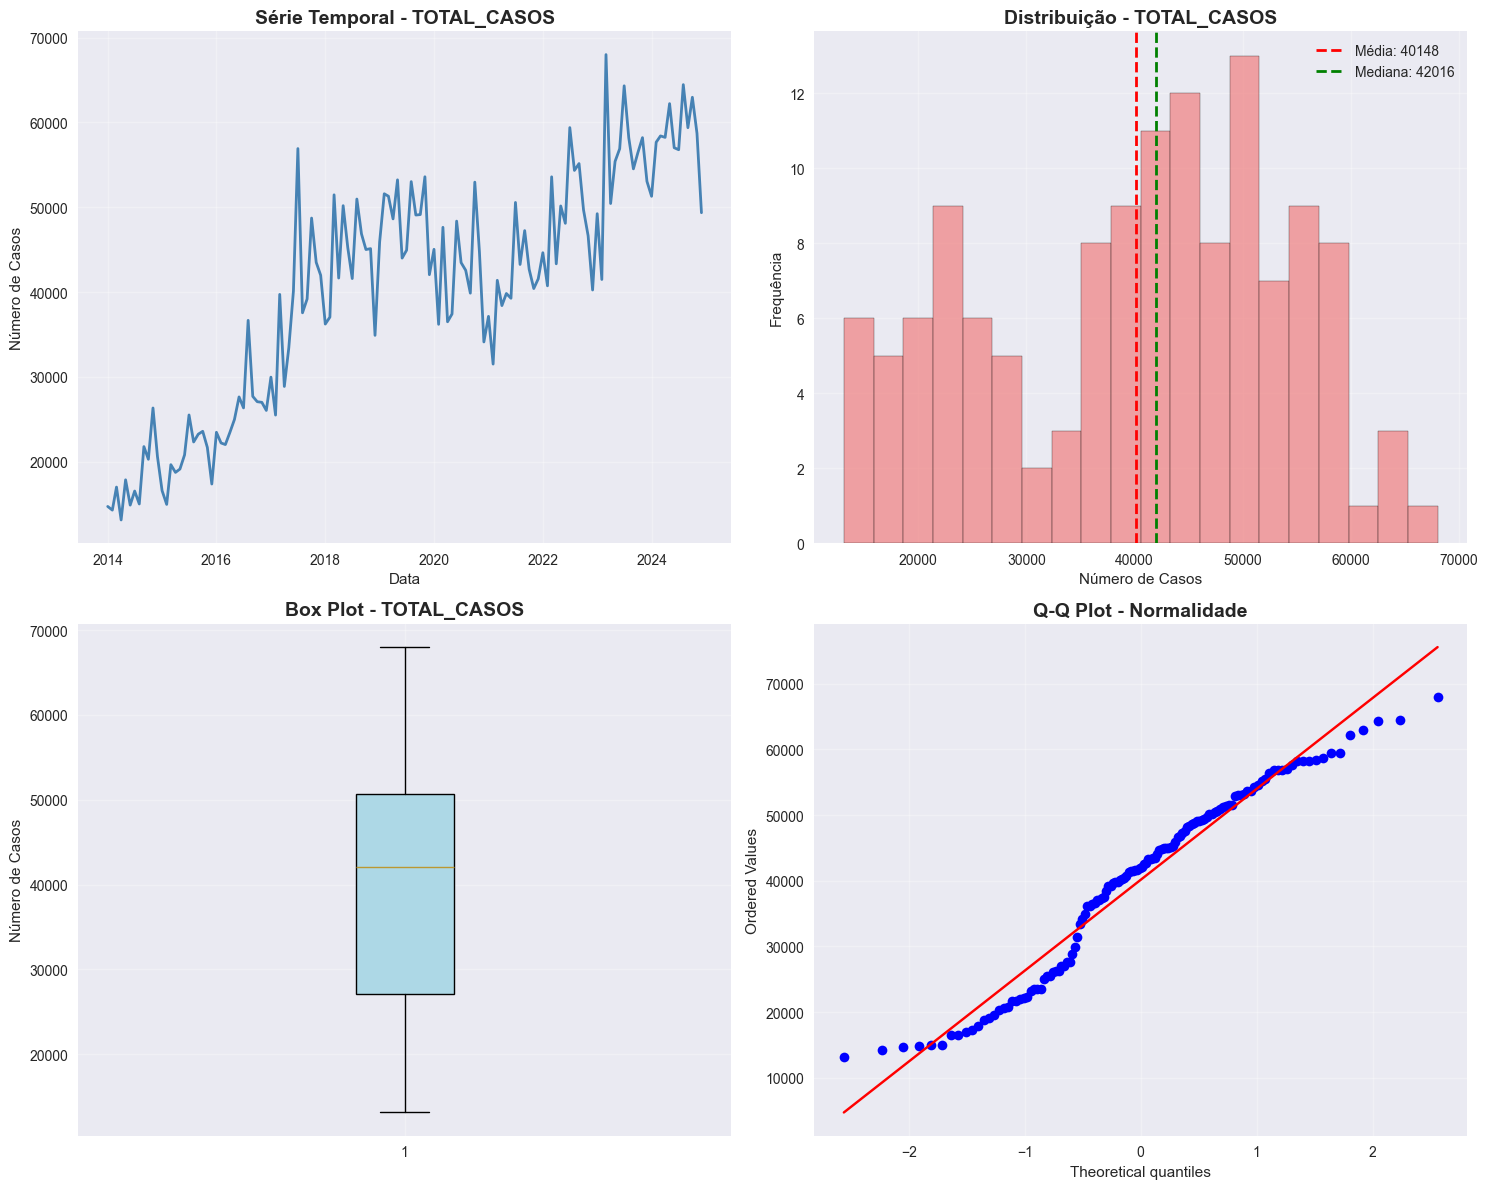


 Teste de Normalidade (Shapiro-Wilk):
Estatística: 0.9567, p-value: 0.0003

 Teste de Normalidade (D'Agostino):
Estatística: 18.9024, p-value: 0.0001
❌ Dados NÃO seguem distribuição normal (p ≤ 0.05)


In [6]:
# Visualizações da variável target
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Série temporal
axes[0,0].plot(df.index, target, linewidth=2, color='steelblue')
axes[0,0].set_title('Série Temporal - TOTAL_CASOS', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Data')
axes[0,0].set_ylabel('Número de Casos')
axes[0,0].grid(True, alpha=0.3)

# 2. Histograma
axes[0,1].hist(target, bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].axvline(target.mean(), color='red', linestyle='--', linewidth=2, label=f'Média: {target.mean():.0f}')
axes[0,1].axvline(target.median(), color='green', linestyle='--', linewidth=2, label=f'Mediana: {target.median():.0f}')
axes[0,1].set_title('Distribuição - TOTAL_CASOS', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Número de Casos')
axes[0,1].set_ylabel('Frequência')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Box plot
axes[1,0].boxplot(target, patch_artist=True, boxprops=dict(facecolor='lightblue'))
axes[1,0].set_title('Box Plot - TOTAL_CASOS', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('Número de Casos')
axes[1,0].grid(True, alpha=0.3)

# 4. Q-Q plot para normalidade
from scipy.stats import probplot
probplot(target, dist="norm", plot=axes[1,1])
axes[1,1].set_title('Q-Q Plot - Normalidade', fontsize=14, fontweight='bold')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Teste de normalidade
from scipy.stats import shapiro, normaltest

# Shapiro-Wilk (para amostras pequenas)
if len(target) <= 5000:
    shapiro_stat, shapiro_p = shapiro(target)
    print(f"\n Teste de Normalidade (Shapiro-Wilk):")
    print(f"Estatística: {shapiro_stat:.4f}, p-value: {shapiro_p:.4f}")

# D'Agostino (para amostras maiores)
dagostino_stat, dagostino_p = normaltest(target)
print(f"\n Teste de Normalidade (D'Agostino):")
print(f"Estatística: {dagostino_stat:.4f}, p-value: {dagostino_p:.4f}")

if shapiro_p > 0.05 or dagostino_p > 0.05:
    print("✅ Dados seguem distribuição normal (p > 0.05)")
else:
    print("❌ Dados NÃO seguem distribuição normal (p ≤ 0.05)")


## 3. Análise de Série Temporal


 Decomposição da Série Temporal


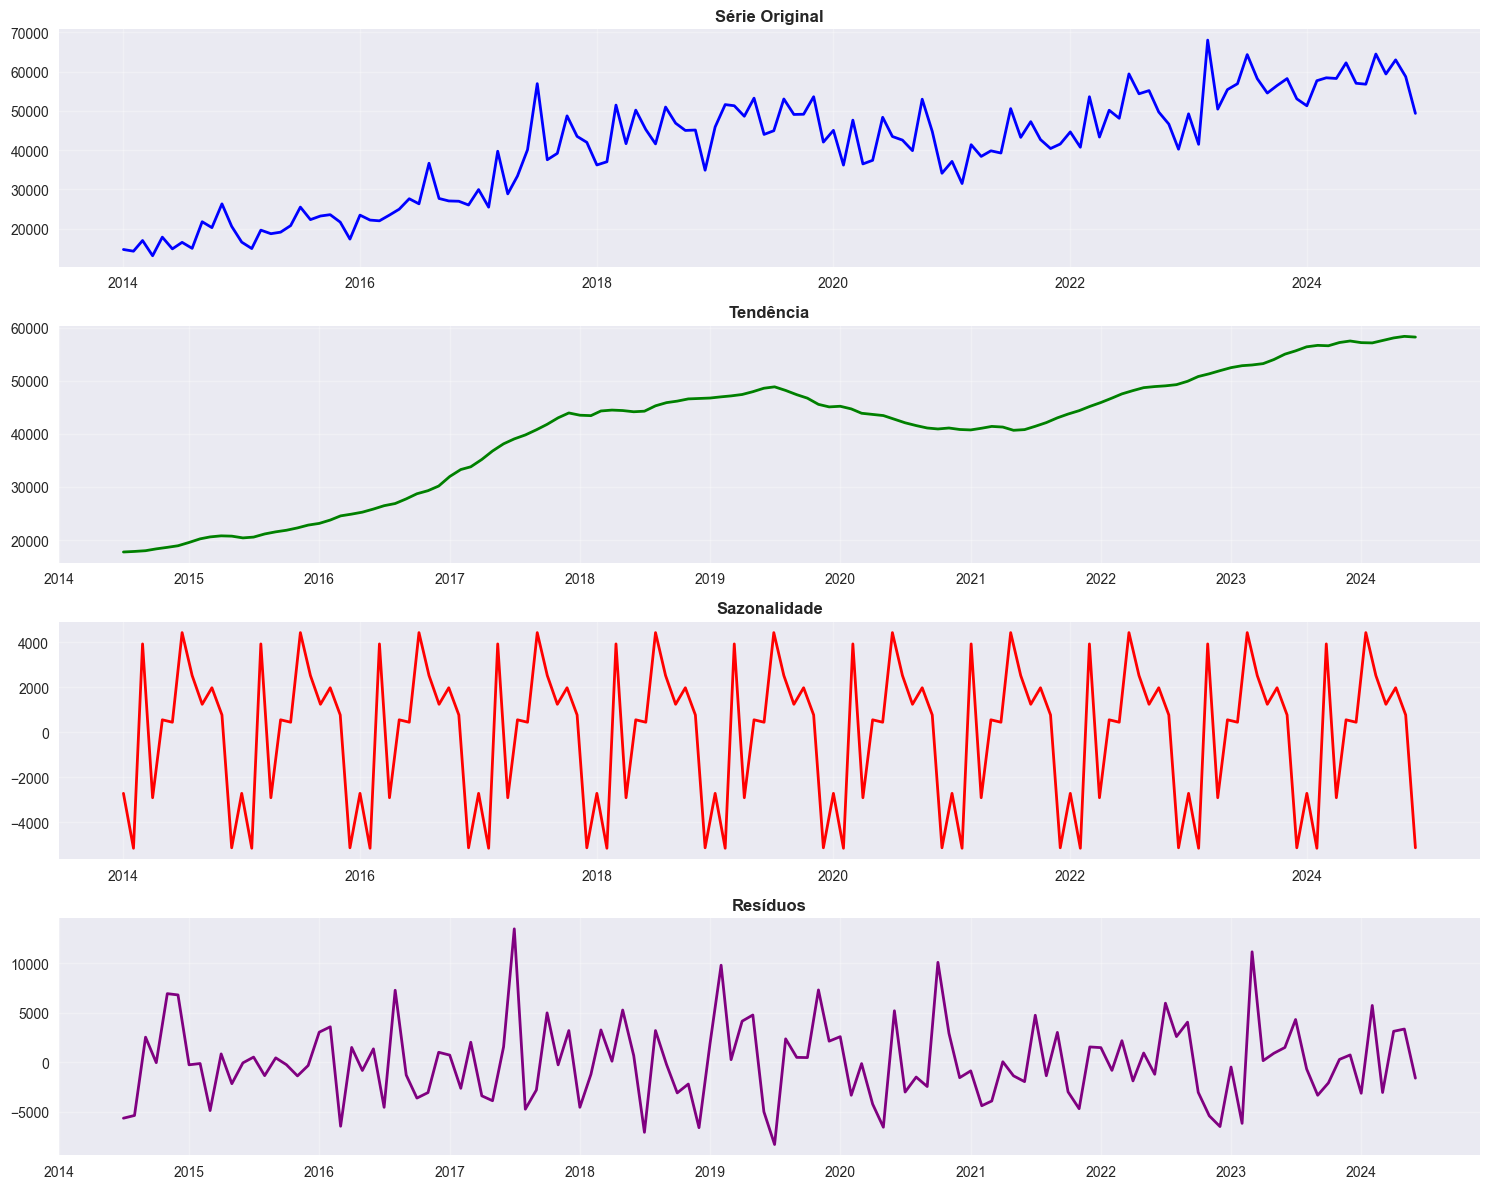

 Força da Sazonalidade: 0.050
 Força da Tendência: 0.709
❌ Série NÃO apresenta sazonalidade significativa


In [7]:
# Decomposição da série temporal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

print(" Decomposição da Série Temporal")
print("="*40)

# Decomposição aditiva
decomposition = seasonal_decompose(target, model='additive', period=12)

fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# Série original
axes[0].plot(decomposition.observed, color='blue', linewidth=2)
axes[0].set_title('Série Original', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Tendência
axes[1].plot(decomposition.trend, color='green', linewidth=2)
axes[1].set_title('Tendência', fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Sazonalidade
axes[2].plot(decomposition.seasonal, color='red', linewidth=2)
axes[2].set_title('Sazonalidade', fontweight='bold')
axes[2].grid(True, alpha=0.3)

# Resíduos
axes[3].plot(decomposition.resid, color='purple', linewidth=2)
axes[3].set_title('Resíduos', fontweight='bold')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análise da sazonalidade
seasonal_strength = np.var(decomposition.seasonal) / np.var(decomposition.observed)
trend_strength = np.var(decomposition.trend) / np.var(decomposition.observed)

print(f" Força da Sazonalidade: {seasonal_strength:.3f}")
print(f" Força da Tendência: {trend_strength:.3f}")

if seasonal_strength > 0.1:
    print("✅ Série apresenta sazonalidade significativa")
else:
    print("❌ Série NÃO apresenta sazonalidade significativa")


 Teste de Estacionaridade (Augmented Dickey-Fuller)
Estatística ADF: -1.7274
p-value: 0.4171
Valores críticos:
  1%: -3.4825
  5%: -2.8844
  10%: -2.5790
❌ Série NÃO é estacionária (p ≥ 0.05)


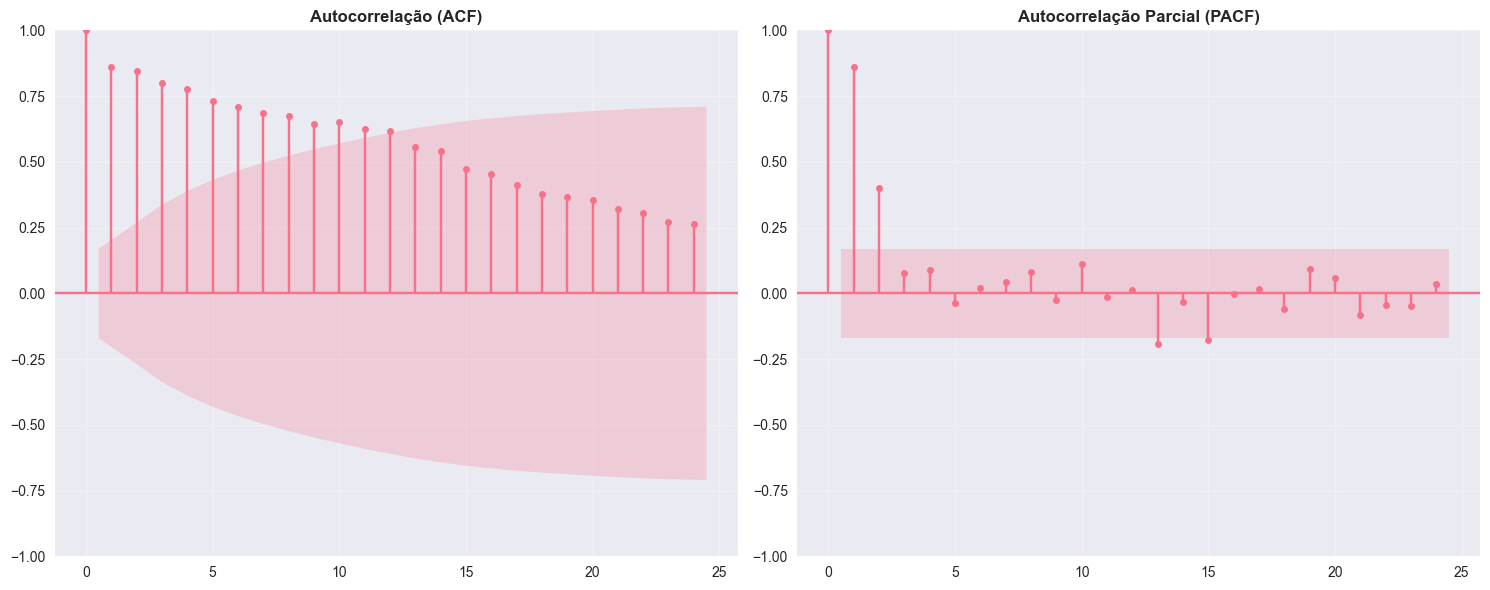

In [8]:
# Teste de estacionaridade (ADF)
print(" Teste de Estacionaridade (Augmented Dickey-Fuller)")
print("="*50)

adf_result = adfuller(target.dropna())
adf_statistic = adf_result[0]
adf_pvalue = adf_result[1]
adf_critical = adf_result[4]

print(f"Estatística ADF: {adf_statistic:.4f}")
print(f"p-value: {adf_pvalue:.4f}")
print(f"Valores críticos:")
for key, value in adf_critical.items():
    print(f"  {key}: {value:.4f}")

if adf_pvalue < 0.05:
    print("✅ Série é estacionária (p < 0.05)")
else:
    print("❌ Série NÃO é estacionária (p ≥ 0.05)")

# ACF e PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

plot_acf(target, ax=axes[0], lags=24, alpha=0.05)
axes[0].set_title('Autocorrelação (ACF)', fontweight='bold')
axes[0].grid(True, alpha=0.3)

plot_pacf(target, ax=axes[1], lags=24, alpha=0.05)
axes[1].set_title('Autocorrelação Parcial (PACF)', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 4. Análise de Correlações e Variáveis Exógenas


🔗 Análise de Correlações
Correlações com TOTAL_CASOS:
  QT_ELEITOR: 0.785
  VAREJO_AMPLIADO: 0.288
  VAREJO_RESTRITO: 0.178
  TAXA_DESOCUPACAO: 0.066
  INADIMPLENCIA: -0.030
  TAXA_SELIC: -0.226
  IPCA: -0.277
  qt_acidente: -0.808

💾 Matriz de correlação salva em:
   📁 data/matriz_correlacao.png
   📁 data/matriz_correlacao.pdf


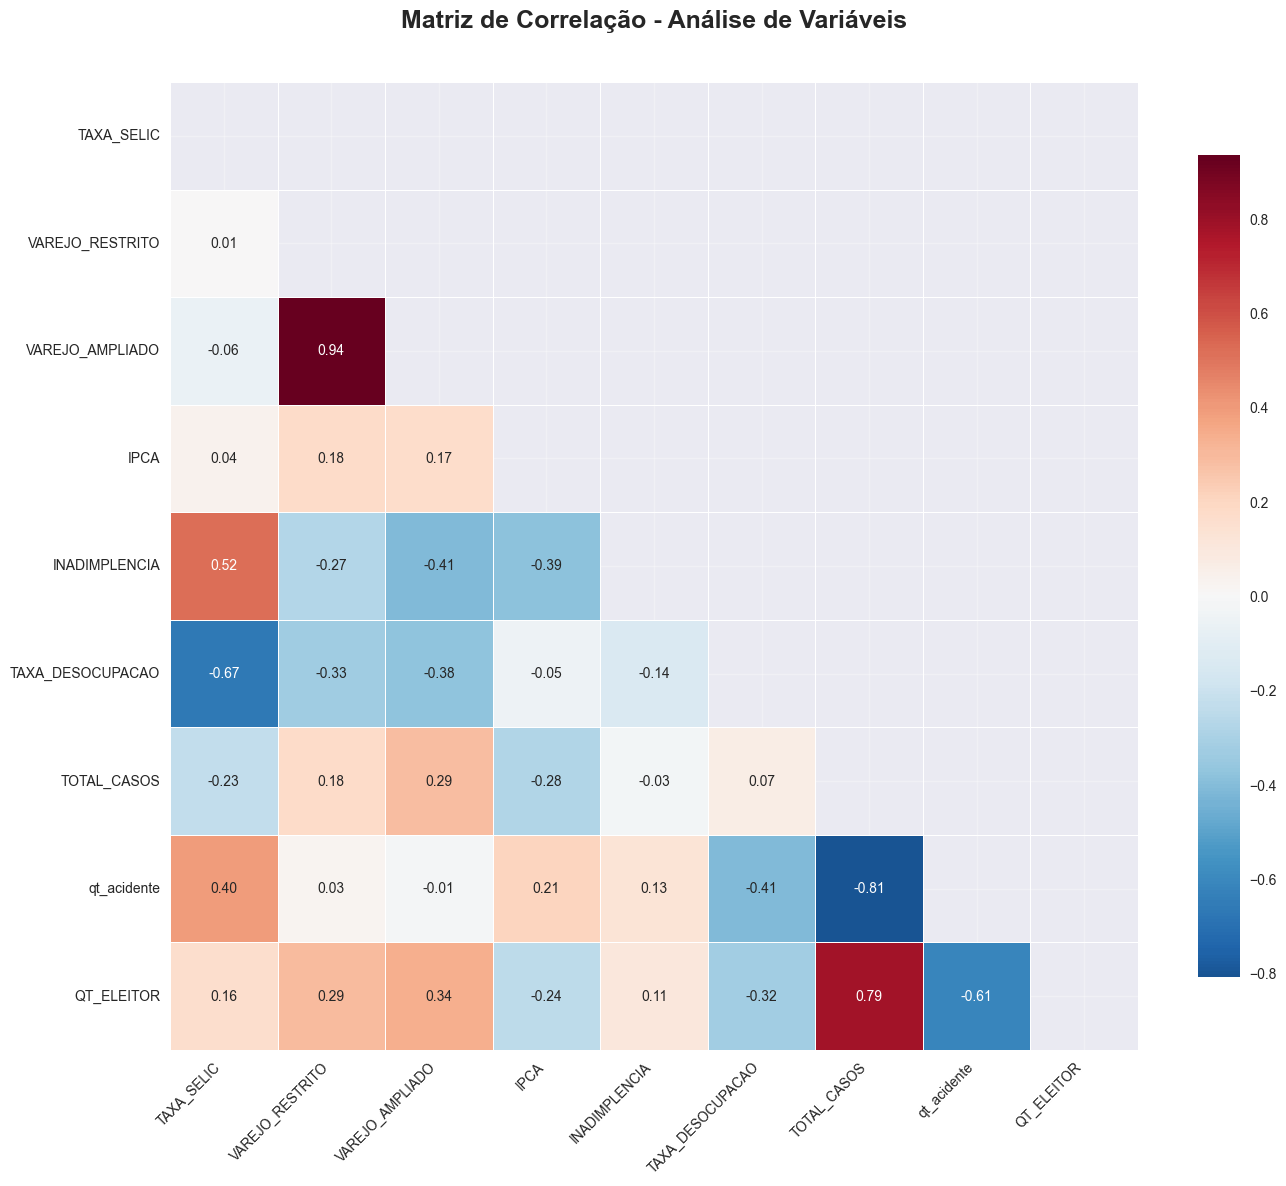

   📁 data/matriz_correlacao_dados.csv
   📁 data/correlacoes_target.csv

📊 Análise de Multicolinearidade (VIF)

Resultados do VIF:


,Variável,VIF
2,VAREJO_AMPLIADO,2004.997050
1,VAREJO_RESTRITO,1270.203653
8,QT_ELEITOR,593.594093
4,INADIMPLENCIA,156.042233
6,TOTAL_CASOS,62.146196
7,qt_acidente,55.176975
5,TAXA_DESOCUPACAO,43.850593
0,TAXA_SELIC,24.442379
3,IPCA,3.505459


💾 Análise VIF salva em: data/analise_vif.csv

⚠️  Variáveis com alta multicolinearidade (VIF > 10):
   🔴 VAREJO_AMPLIADO: VIF = 2005.00
   🔴 VAREJO_RESTRITO: VIF = 1270.20
   🔴 QT_ELEITOR: VIF = 593.59
   🔴 INADIMPLENCIA: VIF = 156.04
   🔴 TOTAL_CASOS: VIF = 62.15
   🔴 qt_acidente: VIF = 55.18
   🔴 TAXA_DESOCUPACAO: VIF = 43.85
   🔴 TAXA_SELIC: VIF = 24.44
💾 Variáveis problemáticas salvas em: data/variaveis_alta_multicolinearidade.csv

🎯 Análise concluída! Todos os arquivos salvos na pasta 'data/'


In [9]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Criar pasta data se não existir
os.makedirs('data', exist_ok=True)

# Matriz de correlação
print("🔗 Análise de Correlações")
print("="*50)

# Calcular correlações com a variável target
correlations = df.corr()['TOTAL_CASOS'].sort_values(ascending=False)
print("Correlações com TOTAL_CASOS:")
for var, corr in correlations.items():
    if var != 'TOTAL_CASOS':
        print(f"  {var}: {corr:.3f}")

# Visualização melhorada da matriz de correlação
plt.figure(figsize=(14, 12))
correlation_matrix = df.corr()

# Criar máscara para mostrar apenas triângulo inferior
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plotar heatmap com melhor formatação
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={"shrink": .8},
            annot_kws={'size': 10},
            linewidths=0.5,
            linecolor='white')

plt.title('Matriz de Correlação - Análise de Variáveis\n', 
          fontsize=18, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Salvar a matriz de correlação
plt.savefig('data/matriz_correlacao.png', 
            dpi=300, 
            bbox_inches='tight', 
            facecolor='white')
plt.savefig('data/matriz_correlacao.pdf', 
            bbox_inches='tight', 
            facecolor='white')

print("\n💾 Matriz de correlação salva em:")
print("   📁 data/matriz_correlacao.png")
print("   📁 data/matriz_correlacao.pdf")

plt.show()

# Salvar também os dados da matriz de correlação em CSV
correlation_matrix.to_csv('data/matriz_correlacao_dados.csv', 
                         float_format='%.3f')
print("   📁 data/matriz_correlacao_dados.csv")

# Salvar correlações com target em CSV
correlations_df = pd.DataFrame(correlations).reset_index()
correlations_df.columns = ['VARIÁVEL', 'CORRELAÇÃO_COM_TOTAL_CASOS']
correlations_df.to_csv('data/correlacoes_target.csv', 
                      index=False, float_format='%.3f')
print("   📁 data/correlacoes_target.csv")

# Análise de multicolinearidade (VIF)
print("\n" + "="*50)
print("📊 Análise de Multicolinearidade (VIF)")
print("="*50)

# Selecionar apenas variáveis numéricas para VIF
numeric_vars = df.select_dtypes(include=[np.number]).columns
vif_data = df[numeric_vars].dropna()

# Calcular VIF
vif_df = pd.DataFrame()
vif_df["Variável"] = vif_data.columns
vif_df["VIF"] = [variance_inflation_factor(vif_data.values, i) 
                 for i in range(len(vif_data.columns))]

vif_df = vif_df.sort_values('VIF', ascending=False)

print("\nResultados do VIF:")
display(vif_df)

# Salvar resultados do VIF
vif_df.to_csv('data/analise_vif.csv', index=False, float_format='%.2f')
print("💾 Análise VIF salva em: data/analise_vif.csv")

# Identificar variáveis com alta multicolinearidade
high_vif = vif_df[vif_df['VIF'] > 10]
if len(high_vif) > 0:
    print(f"\n⚠️  Variáveis com alta multicolinearidade (VIF > 10):")
    for _, row in high_vif.iterrows():
        print(f"   🔴 {row['Variável']}: VIF = {row['VIF']:.2f}")
        
    # Salvar variáveis problemáticas
    high_vif.to_csv('data/variaveis_alta_multicolinearidade.csv', index=False)
    print("💾 Variáveis problemáticas salvas em: data/variaveis_alta_multicolinearidade.csv")
else:
    print("\n✅ Nenhuma variável com alta multicolinearidade detectada")

print("\n" + "="*50)
print("🎯 Análise concluída! Todos os arquivos salvos na pasta 'data/'")
print("="*50)

 Análise de Cross-Correlation com Defasagens
TAXA_SELIC: Melhor defasagem = -12 meses, Corr = -0.386
IPCA: Melhor defasagem = 2 meses, Corr = -0.307
TAXA_DESOCUPACAO: Melhor defasagem = 12 meses, Corr = 0.328
INADIMPLENCIA: Melhor defasagem = -12 meses, Corr = -0.323


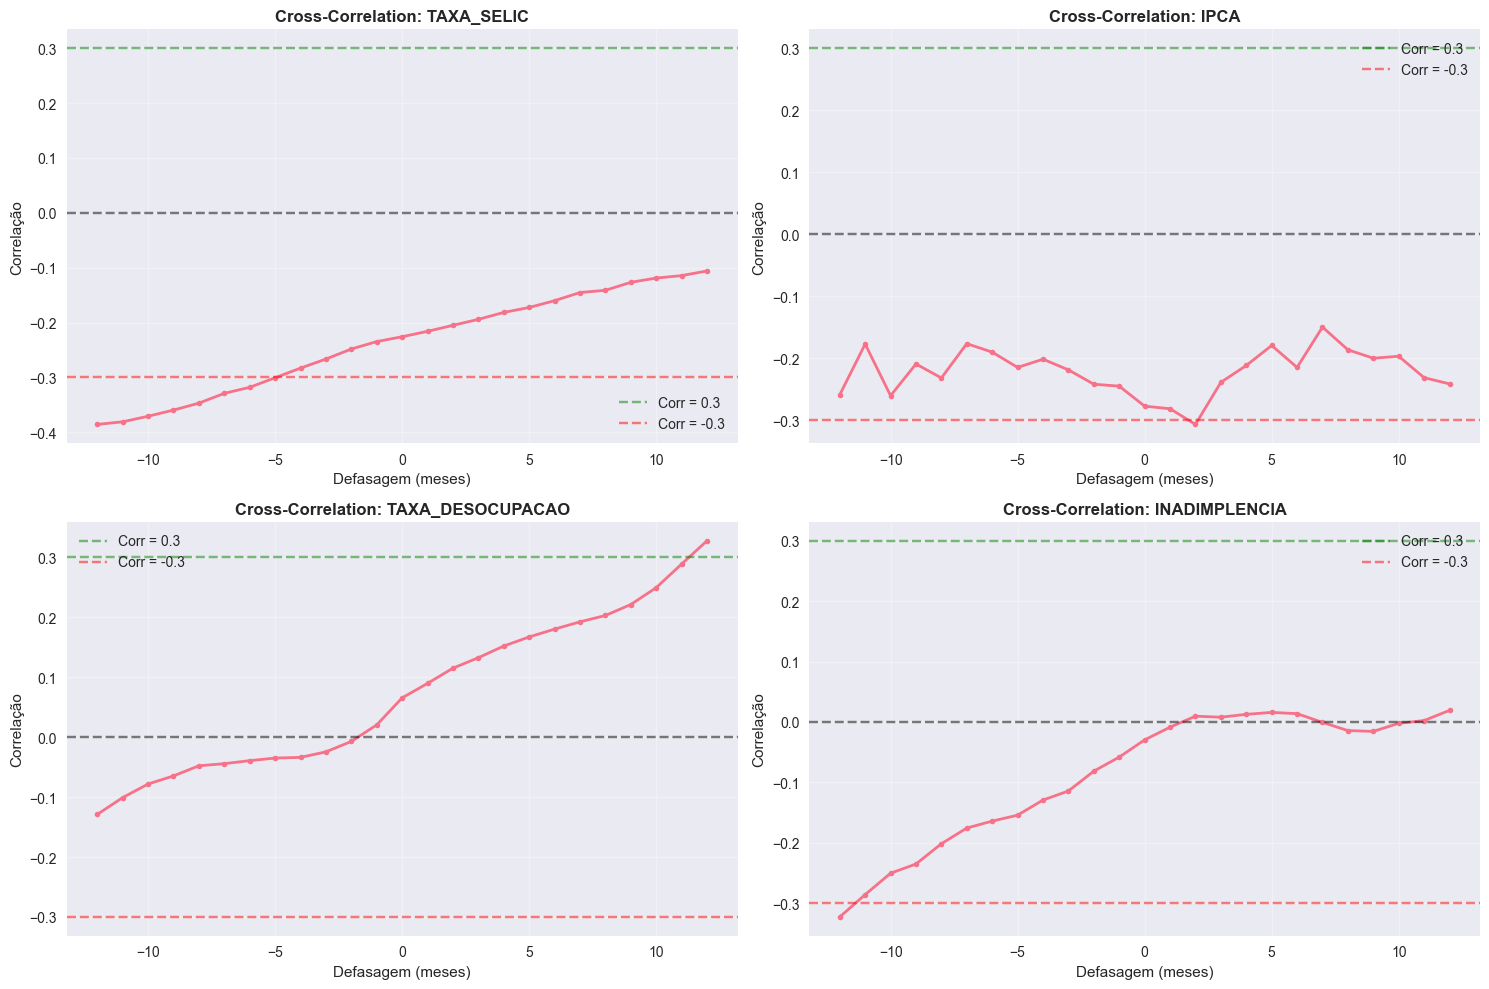

In [10]:
# Análise de cross-correlation com defasagens
print(" Análise de Cross-Correlation com Defasagens")
print("="*50)

# Variáveis exógenas mais promissoras (baseado na correlação)
exogenous_vars = ['TAXA_SELIC', 'IPCA', 'TAXA_DESOCUPACAO', 'INADIMPLENCIA']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, var in enumerate(exogenous_vars):
    if var in df.columns:
        # Calcular cross-correlation com defasagens de -12 a +12 meses
        from scipy.stats import pearsonr
        
        lags = range(-12, 13)
        correlations = []
        
        for lag in lags:
            if lag < 0:
                # Defasagem negativa: variável exógena no futuro
                if len(df) + lag > 0:
                    corr, _ = pearsonr(target[:lag], df[var][-lag:])
                else:
                    corr = np.nan
            elif lag > 0:
                # Defasagem positiva: variável exógena no passado
                if len(df) - lag > 0:
                    corr, _ = pearsonr(target[lag:], df[var][:-lag])
                else:
                    corr = np.nan
            else:
                # Sem defasagem
                corr, _ = pearsonr(target, df[var])
            
            correlations.append(corr)
        
        # Plot
        axes[i].plot(lags, correlations, 'o-', linewidth=2, markersize=4)
        axes[i].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[i].axhline(y=0.3, color='green', linestyle='--', alpha=0.5, label='Corr = 0.3')
        axes[i].axhline(y=-0.3, color='red', linestyle='--', alpha=0.5, label='Corr = -0.3')
        axes[i].set_title(f'Cross-Correlation: {var}', fontweight='bold')
        axes[i].set_xlabel('Defasagem (meses)')
        axes[i].set_ylabel('Correlação')
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()
        
        # Encontrar melhor defasagem
        max_corr_idx = np.nanargmax(np.abs(correlations))
        best_lag = lags[max_corr_idx]
        best_corr = correlations[max_corr_idx]
        
        print(f"{var}: Melhor defasagem = {best_lag} meses, Corr = {best_corr:.3f}")

plt.tight_layout()
plt.show()


## 4.1. Análise de Variáveis de Alta Correlação

### Variáveis com Maior Correlação com TOTAL_CASOS
Baseado na matriz de correlação, identificamos variáveis com correlações muito fortes que merecem análise especial:


In [11]:
# Análise detalhada das variáveis de alta correlação
print(" Análise de Variáveis de Alta Correlação com TOTAL_CASOS")
print("="*60)

# Variáveis com maior correlação (positiva e negativa)
high_corr_vars = ['qt_acidente', 'QT_ELEITOR', 'VAREJO_RESTRITO', 'VAREJO_AMPLIADO']

print("Correlações com TOTAL_CASOS:")
for var in high_corr_vars:
    if var in df.columns:
        corr = df[var].corr(df['TOTAL_CASOS'])
        print(f"  {var}: {corr:.3f}")

print("\n Análise de Multicolinearidade entre variáveis de alta correlação:")
# Verificar multicolinearidade entre essas variáveis
from itertools import combinations

for var1, var2 in combinations(high_corr_vars, 2):
    if var1 in df.columns and var2 in df.columns:
        corr = df[var1].corr(df[var2])
        print(f"  {var1} vs {var2}: {corr:.3f}")
        if abs(corr) > 0.7:
            print(f"      ALTA MULTICOLINEARIDADE detectada!")
        elif abs(corr) > 0.5:
            print(f"    Multicolinearidade moderada")
        else:
            print(f"    Correlação aceitável")


 Análise de Variáveis de Alta Correlação com TOTAL_CASOS
Correlações com TOTAL_CASOS:
  qt_acidente: -0.808
  QT_ELEITOR: 0.785
  VAREJO_RESTRITO: 0.178
  VAREJO_AMPLIADO: 0.288

 Análise de Multicolinearidade entre variáveis de alta correlação:
  qt_acidente vs QT_ELEITOR: -0.613
    Multicolinearidade moderada
  qt_acidente vs VAREJO_RESTRITO: 0.026
    Correlação aceitável
  qt_acidente vs VAREJO_AMPLIADO: -0.014
    Correlação aceitável
  QT_ELEITOR vs VAREJO_RESTRITO: 0.289
    Correlação aceitável
  QT_ELEITOR vs VAREJO_AMPLIADO: 0.340
    Correlação aceitável
  VAREJO_RESTRITO vs VAREJO_AMPLIADO: 0.936
      ALTA MULTICOLINEARIDADE detectada!


In [12]:
# Análise de causalidade e interpretabilidade
print("\n Análise de Causalidade e Interpretabilidade:")
print("="*50)

causality_analysis = {
    'qt_acidente': {
        'correlation': df['qt_acidente'].corr(df['TOTAL_CASOS']),
        'interpretation': 'Acidentes podem gerar processos judiciais (causalidade plausível)',
        'forecast_difficulty': 'Média - depende de fatores externos (clima, trânsito, etc.)',
        'recommendation': 'INCLUIR - alta correlação e causalidade plausível'
    },
    'QT_ELEITOR': {
        'correlation': df['QT_ELEITOR'].corr(df['TOTAL_CASOS']),
        'interpretation': 'Proxy para população - mais eleitores = mais população = mais casos',
        'forecast_difficulty': 'Baixa - crescimento populacional é previsível',
        'recommendation': 'INCLUIR - alta correlação e fácil previsão'
    },
    'VAREJO_RESTRITO': {
        'correlation': df['VAREJO_RESTRITO'].corr(df['TOTAL_CASOS']),
        'interpretation': 'Atividade econômica pode influenciar litigiosidade',
        'forecast_difficulty': 'Média - depende de fatores macroeconômicos',
        'recommendation': 'AVALIAR - boa correlação mas multicolinearidade com VAREJO_AMPLIADO'
    },
    'VAREJO_AMPLIADO': {
        'correlation': df['VAREJO_AMPLIADO'].corr(df['TOTAL_CASOS']),
        'interpretation': 'Atividade econômica ampliada pode influenciar litigiosidade',
        'forecast_difficulty': 'Média - depende de fatores macroeconômicos',
        'recommendation': 'AVALIAR - boa correlação mas multicolinearidade com VAREJO_RESTRITO'
    }
}

for var, analysis in causality_analysis.items():
    print(f"\n {var}:")
    print(f"  Correlação: {analysis['correlation']:.3f}")
    print(f"  Interpretação: {analysis['interpretation']}")
    print(f"  Dificuldade de previsão: {analysis['forecast_difficulty']}")
    print(f"  Recomendação: {analysis['recommendation']}")


 Análise de Causalidade e Interpretabilidade:

 qt_acidente:
  Correlação: -0.808
  Interpretação: Acidentes podem gerar processos judiciais (causalidade plausível)
  Dificuldade de previsão: Média - depende de fatores externos (clima, trânsito, etc.)
  Recomendação: INCLUIR - alta correlação e causalidade plausível

 QT_ELEITOR:
  Correlação: 0.785
  Interpretação: Proxy para população - mais eleitores = mais população = mais casos
  Dificuldade de previsão: Baixa - crescimento populacional é previsível
  Recomendação: INCLUIR - alta correlação e fácil previsão

 VAREJO_RESTRITO:
  Correlação: 0.178
  Interpretação: Atividade econômica pode influenciar litigiosidade
  Dificuldade de previsão: Média - depende de fatores macroeconômicos
  Recomendação: AVALIAR - boa correlação mas multicolinearidade com VAREJO_AMPLIADO

 VAREJO_AMPLIADO:
  Correlação: 0.288
  Interpretação: Atividade econômica ampliada pode influenciar litigiosidade
  Dificuldade de previsão: Média - depende de fatores

In [13]:
# Atualizar lista de variáveis exógenas para incluir as de alta correlação
print("\n Atualizando Lista de Variáveis Exógenas:")
print("="*45)

# Lista original (correlações fracas)
original_vars = ['TAXA_SELIC', 'IPCA', 'TAXA_DESOCUPACAO', 'INADIMPLENCIA']
print("Variáveis originais (correlações fracas):")
for var in original_vars:
    if var in df.columns:
        corr = df[var].corr(df['TOTAL_CASOS'])
        print(f"  {var}: {corr:.3f}")

# Lista atualizada (incluindo alta correlação)
updated_vars = ['TAXA_SELIC', 'IPCA', 'TAXA_DESOCUPACAO', 'INADIMPLENCIA', 'qt_acidente', 'QT_ELEITOR']
print(f"\nVariáveis atualizadas (incluindo alta correlação):")
for var in updated_vars:
    if var in df.columns:
        corr = df[var].corr(df['TOTAL_CASOS'])
        print(f"  {var}: {corr:.3f}")

print(f"\n Recomendação: Usar {len(updated_vars)} variáveis exógenas")
print("   - Manter variáveis econômicas tradicionais")
print("   - Adicionar qt_acidente (alta correlação negativa)")
print("   - Adicionar QT_ELEITOR (alta correlação positiva)")
print("   - Monitorar multicolinearidade no VIF")



 Atualizando Lista de Variáveis Exógenas:
Variáveis originais (correlações fracas):
  TAXA_SELIC: -0.226
  IPCA: -0.277
  TAXA_DESOCUPACAO: 0.066
  INADIMPLENCIA: -0.030

Variáveis atualizadas (incluindo alta correlação):
  TAXA_SELIC: -0.226
  IPCA: -0.277
  TAXA_DESOCUPACAO: 0.066
  INADIMPLENCIA: -0.030
  qt_acidente: -0.808
  QT_ELEITOR: 0.785

 Recomendação: Usar 6 variáveis exógenas
   - Manter variáveis econômicas tradicionais
   - Adicionar qt_acidente (alta correlação negativa)
   - Adicionar QT_ELEITOR (alta correlação positiva)
   - Monitorar multicolinearidade no VIF


In [14]:
# Calcular correlação (se ainda não foi feito)
correlations = df.corr()  # <-- note os parênteses

# Capturar melhor correlação exógena (excluindo a própria variável target)
correlations_target = correlations[target.name].drop(target.name).sort_values(ascending=False)
melhor_corr_exogena = f"{correlations_target.index[0]}: {correlations_target.iloc[0]:.3f}"

# Criar resumo estatístico
eda_summary = {
    'Métrica': [
        'Período_Análise',
        'Total_Observações', 
        'Dados_Faltantes',
        'Outliers_Target',
        'Média_Target',
        'Desvio_Padrão_Target',
        'Skewness_Target',
        'Kurtosis_Target',
        'Série_Estacionária',
        'Força_Sazonalidade',
        'Força_Tendência',
        'Melhor_Corr_Exógena',
        'VIF_Máximo'
    ],
    'Valor': [
        f"{df.index.min().strftime('%Y-%m')} a {df.index.max().strftime('%Y-%m')}",
        len(df),
        df.isnull().sum().sum(),
        len(outliers),
        round(target.mean(), 2),
        round(target.std(), 2),
        round(stats.skew(target), 3),
        round(stats.kurtosis(target), 3),
        'Sim' if adf_pvalue < 0.05 else 'Não',
        round(seasonal_strength, 3),
        round(trend_strength, 3),
        melhor_corr_exogena,
        round(vif_df['VIF'].max(), 2)
    ]
}

eda_summary_df = pd.DataFrame(eda_summary)
eda_summary_df.to_csv('../reports/eda_summary.csv', index=False)
print(" Resumo salvo em reports/eda_summary.csv")

print("\n RESUMO DO EDA:")
print("="*40)
display(eda_summary_df)

 Resumo salvo em reports/eda_summary.csv

 RESUMO DO EDA:


,Métrica,Valor
0,Período_Análise,2014-01 a 2024-12
1,Total_Observações,132
2,Dados_Faltantes,0
3,Outliers_Target,0
4,Média_Target,40147.87
5,Desvio_Padrão_Target,13932.64
6,Skewness_Target,-0.285
7,Kurtosis_Target,-0.962
8,Série_Estacionária,Não
9,Força_Sazonalidade,0.05
